In [63]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [64]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [65]:
len(words)

32033

In [66]:
# build the vocabulary of character and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [67]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] #crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [68]:
# build the dataset

def build_dataset(words):
    block_size = 3 # context length: how many characters do we take to predict the next one?
    X, Y = [], []
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] #crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])
len(words), n1, n2, n2 - n1

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


(32033, 25626, 28829, 3203)

In [69]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [70]:
# to iste co C[5] kvoli niecomu
# F.one_hot(torch.tensor(5), num_classes=27).float() @ C

In [71]:
# all these 5 lines do the same
#torch.cat([emb[:, 0 :], emb[:, 1 :], emb[:, 2 :]], 1).shape
#torch.cat(torch.unbind(emb, 1), 1).shape
#h = emb.view(32, 6) @ W1 + b1
#h = emb.view(emb.shape[0], 6) @ W1 + b1

#h = emb.view(-1, 6) @ W1 + b1 # -1 means the rest
#H = torch.tanh(h)
#h.shape, h

In [72]:
# respectable --------------------------

In [73]:
X.shape, Y.shape # dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [74]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2*5), generator=g)
W1 = torch.randn((6*5, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters) # number of parameters in total


11897

In [75]:
for p in parameters:
    p.requires_grad = True

In [76]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
#lrs

In [77]:
lri = []
lossi = []
stepi = []

In [134]:
for i in range (100000):

    # mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6*5) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    # >>>>>>>>>>
    #counts = logits.exp()
    #prob = counts / counts.sum(1, keepdim=True)
    #loss = -prob[torch.arange(32), Y].log().mean()
    # <<<<<<<<<
    loss = F.cross_entropy(logits, Ytr[ix]) # same as in >>> <<< above
    #print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    #lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    #lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())
        
print(loss.item())

2.1866753101348877


In [79]:
#plt.plot(lri, lossi)

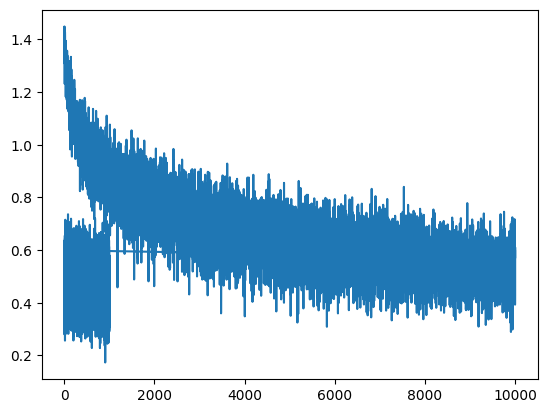

In [97]:
plt.plot(stepi, lossi)

In [133]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6*5) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss.item()

2.3388702869415283

In [82]:
# training split, dev/validation split, test split
# 80%, 10%, 10$%


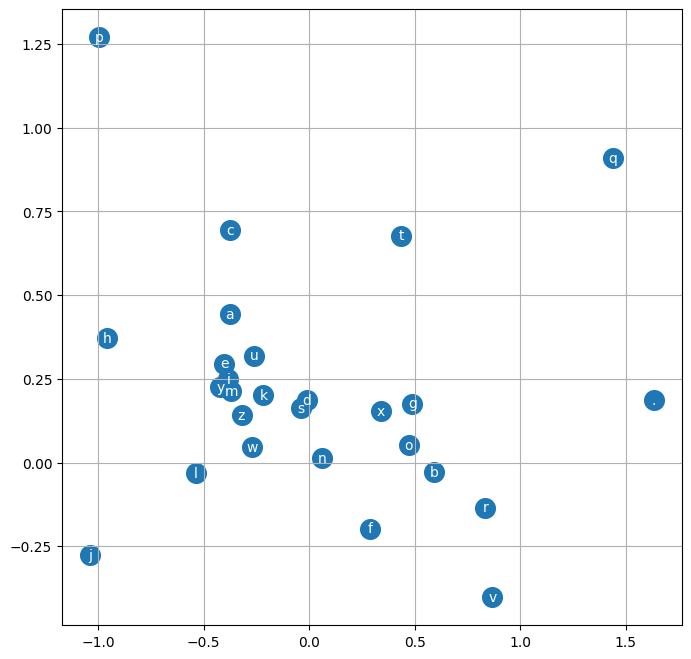

In [83]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [131]:
#sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize wit all ...
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        counts = logits.exp() # counts, equivalent to next character
        probs = counts / counts.sum(1, keepdim=True) # probabilities for next character
        #probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

mora.
mayanleegh.
ndyn.
alarethaniekdrnen.
adered.
eliigh.
porelle.
elieananareelle.
moltea.
noshigergihi.
jeri.
julewallion.
terofouan.
aven.
jamell.
eha.
kaysh.
salyan.
hyl.
salyansuf.
